# Data Preprocess
利用RNN來預測ICLR文章被接受與否

In [159]:
import pandas as pd
import numpy as np
accept = pd.read_excel('ICLR_accepted.xlsx')[0]
reject = pd.read_excel('ICLR_rejected.xlsx')[0]

vocab = {}
for i in range(len(accept)):
    sentence = accept[i].lower().split(' ')
    accept[i] = sentence
    for j in sentence:
        if j not in vocab:
            vocab[j] = len(vocab)+1

for i in range(len(reject)):
    sentence = reject[i].lower().split(' ')
    reject[i] = sentence
    for j in sentence:
        if j not in vocab:
            vocab[j] = len(vocab)+1

print ('Vocabulary：',len(vocab))
vocab

Vocabulary： 2540


{'': 62,
 'synthesizing': 823,
 'interpretability': 1291,
 'sgd': 635,
 'gates': 1437,
 'notion': 1580,
 'distilling': 1668,
 'teachers': 1596,
 'differentially': 314,
 'matrix': 212,
 'm': 1097,
 'beam': 2339,
 'margin': 644,
 'spatio-temporal': 2457,
 'apprentice:': 292,
 'rectified': 611,
 'multi-modal,': 233,
 'wavelets': 1624,
 'algorithms': 474,
 'transaction': 2052,
 'the': 75,
 'primate': 1029,
 'mutual': 2069,
 'recasting': 620,
 'cramer': 1957,
 'anomaly': 520,
 'ambiguous': 1079,
 'sql': 1455,
 'question': 189,
 'resnet': 1750,
 'warm': 1232,
 'estimation': 15,
 'brains': 1545,
 'approaches': 1866,
 'bandwidth': 340,
 'probability': 1557,
 'aggregation': 185,
 'query,': 1076,
 'representing': 1429,
 'separable': 513,
 'dora': 856,
 'resistant': 468,
 'residuals': 1251,
 'facial': 1655,
 'using': 137,
 'anytime': 1741,
 'base': 1523,
 'showdown:': 61,
 'compilation-based': 1147,
 'rbm': 2393,
 'ultra-deep': 1250,
 'performs': 885,
 'can': 162,
 'construction': 1774,
 'inferen

# 用字典編碼

In [162]:
for i,j in enumerate(accept):
    for h,k in enumerate(j):
        accept[i][h] = vocab[k]
        
for i,j in enumerate(reject):
    for h,k in enumerate(j):
        reject[i][h] = vocab[k]        
        
print (accept[:5])
print (reject[:5])

0                    [1, 2, 3, 4, 5, 6, 7, 8]
1                 [9, 10, 11, 12, 13, 14, 15]
2    [16, 17, 18, 19, 20, 21, 22, 23, 24, 22]
3                            [25, 26, 18, 27]
4                    [28, 29, 30, 31, 32, 33]
Name: 0, dtype: object
0                          [208, 1246, 1247, 260]
1         [22, 134, 1425, 334, 335, 74, 75, 1426]
2                    [1427, 287, 22, 477, 4, 958]
3                 [322, 314, 315, 1428, 137, 136]
4    [1429, 1430, 42, 740, 478, 4, 1431, 840, 54]
Name: 0, dtype: object


# Sequence Padding

In [238]:
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEQUENCE_SIZE = 10
accept_tensor = pad_sequence([torch.tensor(i) for i in accept], batch_first=True, padding_value=0)
accept_tensor = accept_tensor[:,:SEQUENCE_SIZE] # 長度限制在10
reject_tensor = pad_sequence([torch.tensor(i) for i in reject], batch_first=True, padding_value=0)
reject_tensor = reject_tensor[:,:SEQUENCE_SIZE]

print ('Size after sequence padding：',accept_tensor.size(), reject_tensor.size())

Size after sequence padding： torch.Size([582, 10]) torch.Size([753, 10])


In [386]:
test_X = torch.cat([accept_tensor[:50], reject_tensor[:50]])
test_Y = torch.cat([torch.ones(50), torch.zeros(50)]).type(torch.LongTensor)

train_X = torch.cat([accept_tensor[50:], reject_tensor[50:]])
train_Y = torch.cat([torch.ones(532), torch.zeros(703)]).type(torch.LongTensor)
print (train_X.size(), test_X.size())
print (train_Y.size(), test_Y.size())

torch.Size([1235, 10]) torch.Size([100, 10])
torch.Size([1235]) torch.Size([100])


# Model

In [413]:
EMB_DIM = 256
HIDDEN_DIM = 128
OUTPUT_SIZE = 2
NUM_LAYERS = 1
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(len(vocab)+1, EMB_DIM) # vocab長度要加1，因為在padding的時候會多一個元素"0"
        self.lstm = nn.LSTM(EMB_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True)
        self.dense = nn.Linear(HIDDEN_DIM, OUTPUT_SIZE) # 攤平輸入dense layer

    def forward(self, input_sentence):
#         print ('\nInput：', input_sentence.size())
        embedding = self.embed(input_sentence)
#         print ('After embedding：', embedding.size())

        h0 = torch.zeros(NUM_LAYERS, embedding.size(0), HIDDEN_DIM)
        c0 = torch.zeros(NUM_LAYERS, embedding.size(0), HIDDEN_DIM)
        
        lstm_out, _ = self.lstm(embedding, (h0, c0)) # .view(len(input_sentence), 1, -1)
#         print ('LSTM output：', lstm_out.size())
        lstm_out = lstm_out[:,-1,:]
#         print ('LSTM output[:,-1,:]：', lstm_out.size())
        output = self.dense(lstm_out)
#         print ('After Dense：', output.size())
        
#         print (lstm_out.size())
#         output = self.dense(lstm_out.view(len(input_sentence), -1))
#         print (output.size())
        # 不須做softmax，pytorch的cross entropy會自動先softmax
        return output

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.embed = nn.Embedding(len(vocab)+1, EMB_DIM) 
        self.rnn = nn.RNN(EMB_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True)
        self.dense = nn.Linear(HIDDEN_DIM, OUTPUT_SIZE)

    def forward(self, input_sentence):

        embedding = self.embed(input_sentence)    
        rnn_out, _ = self.rnn(embedding)
        rnn_out = rnn_out[:,-1,:]

        output = self.dense(rnn_out)
        return output



In [422]:
%%time
import torch.utils.data as Data

EPOCH = 200
BATCH_SIZE = 64
LR = 0.001
model = LSTM()
# model = RNN()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

# 包進data loader
torch_dataset = Data.TensorDataset(train_X, train_Y)
loader = Data.DataLoader(
    dataset=torch_dataset,      
    batch_size=BATCH_SIZE,     
    shuffle=True,   
    num_workers=2,  
)

train_loss, train_acc, test_acc = [], [], []
for epoch in range(1,EPOCH+1):
    for step, (batch_x, batch_y) in enumerate(loader):  
        batch_x = batch_x
        batch_y = batch_y
        output = model(batch_x)              
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # 把這次step的gradient清空
        loss.backward()                 
        optimizer.step()                # apply gradient

        if step % 10 == 0:
            # 紀錄test準確率
            test_output = model(test_X)
            pred_y = torch.max(test_output, 1)[1]
            accuracy_test = torch.sum(pred_y == test_Y).type(torch.FloatTensor) / test_Y.size(0)
                        
            # 紀錄batch準確率
            pred_batch_y = torch.max(output, 1)[1]
            accuracy_batch = torch.sum(pred_batch_y == batch_y).type(torch.FloatTensor) / batch_y.size(0)
            
            print('Epoch:', epoch, '| train loss: %.5f' % loss.data,'| train accuracy: %.3f' % accuracy_batch, '| test accuracy: %.3f' % accuracy_test)
            
    # 紀錄結果
    train_loss.append(loss.data)
    train_acc.append(accuracy_batch)            
    test_acc.append(accuracy_test)

    


Epoch: 1 | train loss: 0.67523 | train accuracy: 0.641 | test accuracy: 0.530
Epoch: 1 | train loss: 0.67136 | train accuracy: 0.609 | test accuracy: 0.510
Epoch: 2 | train loss: 0.67591 | train accuracy: 0.547 | test accuracy: 0.490
Epoch: 2 | train loss: 0.66308 | train accuracy: 0.594 | test accuracy: 0.500
Epoch: 3 | train loss: 0.64500 | train accuracy: 0.609 | test accuracy: 0.510
Epoch: 3 | train loss: 0.65060 | train accuracy: 0.547 | test accuracy: 0.480
Epoch: 4 | train loss: 0.62751 | train accuracy: 0.562 | test accuracy: 0.530
Epoch: 4 | train loss: 0.58290 | train accuracy: 0.766 | test accuracy: 0.560
Epoch: 5 | train loss: 0.49180 | train accuracy: 0.859 | test accuracy: 0.550
Epoch: 5 | train loss: 0.44549 | train accuracy: 0.812 | test accuracy: 0.560
Epoch: 6 | train loss: 0.44510 | train accuracy: 0.766 | test accuracy: 0.560
Epoch: 6 | train loss: 0.32755 | train accuracy: 0.891 | test accuracy: 0.560
Epoch: 7 | train loss: 0.23218 | train accuracy: 0.922 | test ac

Epoch: 53 | train loss: 0.00016 | train accuracy: 1.000 | test accuracy: 0.540
Epoch: 53 | train loss: 0.00071 | train accuracy: 1.000 | test accuracy: 0.530
Epoch: 54 | train loss: 0.00083 | train accuracy: 1.000 | test accuracy: 0.530
Epoch: 54 | train loss: 0.00024 | train accuracy: 1.000 | test accuracy: 0.540
Epoch: 55 | train loss: 0.00363 | train accuracy: 1.000 | test accuracy: 0.540
Epoch: 55 | train loss: 0.00020 | train accuracy: 1.000 | test accuracy: 0.540
Epoch: 56 | train loss: 0.00088 | train accuracy: 1.000 | test accuracy: 0.530
Epoch: 56 | train loss: 0.00010 | train accuracy: 1.000 | test accuracy: 0.530
Epoch: 57 | train loss: 0.05130 | train accuracy: 0.984 | test accuracy: 0.530
Epoch: 57 | train loss: 0.00012 | train accuracy: 1.000 | test accuracy: 0.530
Epoch: 58 | train loss: 0.00073 | train accuracy: 1.000 | test accuracy: 0.530
Epoch: 58 | train loss: 0.00056 | train accuracy: 1.000 | test accuracy: 0.520
Epoch: 59 | train loss: 0.00007 | train accuracy: 1.

Epoch: 105 | train loss: 0.00003 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 105 | train loss: 0.00077 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 106 | train loss: 0.00086 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 106 | train loss: 0.00139 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 107 | train loss: 0.00002 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 107 | train loss: 0.00211 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 108 | train loss: 0.00154 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 108 | train loss: 0.00209 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 109 | train loss: 0.00180 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 109 | train loss: 0.00086 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 110 | train loss: 0.00156 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 110 | train loss: 0.00087 | train accuracy: 1.000 | test accuracy: 0.500
Epoch: 111 | train loss: 0.00003 | train

Epoch: 156 | train loss: 0.00095 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 157 | train loss: 0.00092 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 157 | train loss: 0.00071 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 158 | train loss: 0.00065 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 158 | train loss: 0.00137 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 159 | train loss: 0.00074 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 159 | train loss: 0.00145 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 160 | train loss: 0.00074 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 160 | train loss: 0.00002 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 161 | train loss: 0.00199 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 161 | train loss: 0.00002 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 162 | train loss: 0.00147 | train accuracy: 1.000 | test accuracy: 0.490
Epoch: 162 | train loss: 0.00225 | train

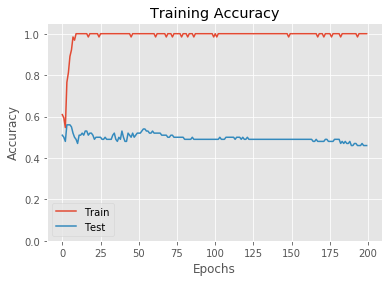

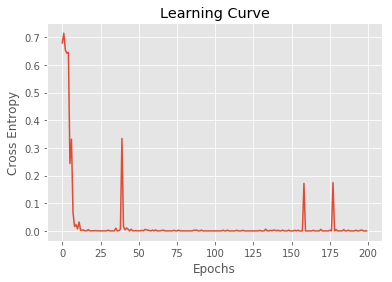

In [423]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0,1.05)
plt.show()

plt.plot(train_loss)
plt.title('Learning Curve')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.show()